In [1]:
# Standard Imports
import numpy as np
from time import time
from matplotlib import pyplot as plt
import os


from pyspecter.SPECTER import SPECTER
from pyspecter.Observables import Observable
# from pyspecter.SpecialObservables import SpecialObservables

# Utils
from pyspecter.utils.data_utils import load_cmsopendata, load_triangles
from pyspecter.utils.plot_utils import newplot, plot_event, hist_with_errors, hist_with_outline

# Jax
from jax import grad, jacobian, jit
import jax.numpy as jnp
from jax import random

# SPECTER
from pyspecter.SpectralEMD_Helper import compute_spectral_representation

2023-11-04 22:20:03.852281: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


In [2]:
R = 0.1
this_dir = ""
this_study = "cmsopendata"

# Load the params 
specter_params_string = f"{this_study}_params.npy"
closed_form_params_string = f"{this_study}_closed_form_params.npy"
shaper_params_string = f"{this_study}_shaper_params.npy"

specter_params = np.load(os.path.join(this_dir, specter_params_string), allow_pickle=True)
closed_form_params = np.load(os.path.join(this_dir, closed_form_params_string), allow_pickle=True)
shaper_params = np.load(os.path.join(this_dir, shaper_params_string), allow_pickle=True)

# Load the EMDs
specter_emds_string = f"{this_study}_sEMDs.npy"
closed_form_emds_string = f"{this_study}_closed_form_sEMDs.npy"
shaper_emds_string = f"{this_study}_shaper_EMDs.npy"

specter_emds = np.load(os.path.join(this_dir, specter_emds_string), allow_pickle=True)
closed_form_emds = np.load(os.path.join(this_dir, closed_form_emds_string), allow_pickle=True)
shaper_emds = np.load(os.path.join(this_dir, shaper_emds_string), allow_pickle=True)

# Parameters 
n_events = 100
epochs = 150

dataset_open, sim_weights, k = load_cmsopendata("~/.energyflow/", "sim", 475, 525, 1.9, 2, pad = 75, n = n_events)
triangle_events, triangle_indices = load_triangles(180, 180, R = 1.0, return_indices=True)

dataset = dataset_open


Max # of particles: 113


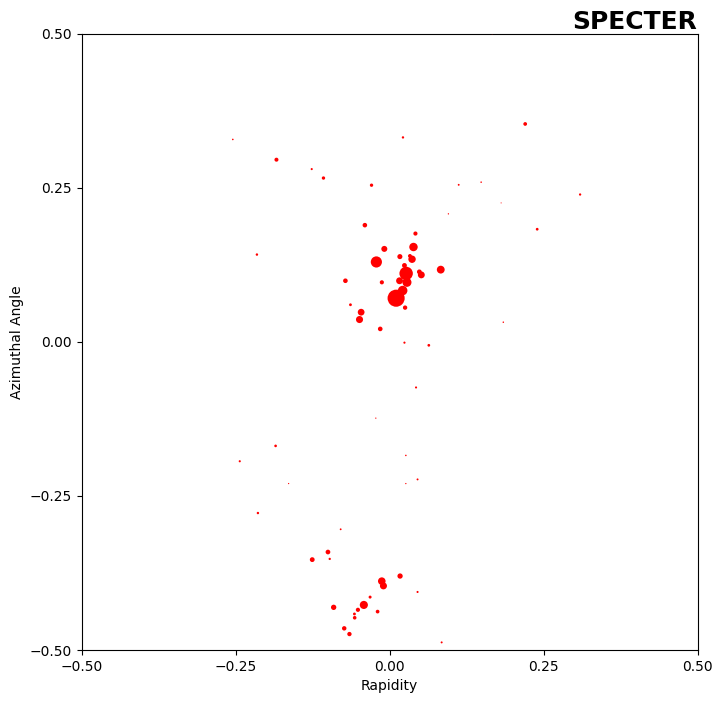

Text(0, 0.5, 'Spectral Density $\\sim 2E_iE_j$')

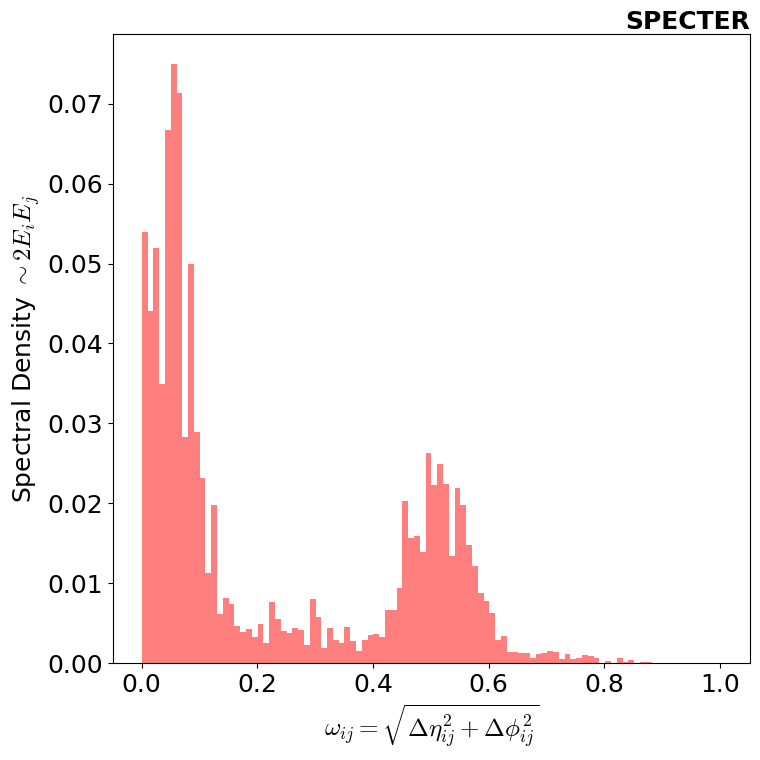

In [3]:
special_event = dataset[0]
fig, ax = newplot()
plot_event(special_event, 0.5, ax, color = "red")

special_event = compute_spectral_representation(special_event)
fig, ax = newplot()
plt.hist(special_event[:,0], bins = 100, color = "red", alpha = 0.5, weights = special_event[:,1])
plt.xlabel(r"$\omega_{ij} = \sqrt{\Delta\eta_{ij}^2 + \Delta\phi_{ij}^2}$")
plt.ylabel(r"Spectral Density $\sim 2E_iE_j$")



In [12]:
# weights such that the points near 0.2 of specter_params have half weight
def reweight(params):

    weights = np.ones_like(params)
    for (i,param) in enumerate(params):
        if param > 0.18 and param < 0.22:
            weights[i] = 0.

    return weights

weights = reweight(specter_params)


In [31]:
alpha_s = 0.12
C_F = 4/3

def quark_splitting_function(z):

    return C_F * (1 + (1-z)**2) / z

def theta(z, R_opt, R = 0.4):

    t = 2 * R * np.sin(z[None,:] * (1-z[None,:]) * np.pi) - np.pi * R_opt[:,None]
    return t > 0

def integral(R_opt, n = 1000):

    z = np.random.uniform(0, 1, size = n)
    probability = quark_splitting_function(z)
    t = theta(z, R_opt)
    return alpha_s / np.pi * np.sum(probability * t, axis = -1)



R_opt = np.linspace(0.001, 0.4, 1000)
probs = integral(R_opt)

0.08815142 0.086695835 0.036151


Text(0.02, 0.9099999999999999, '2011AJets, 10k Events')

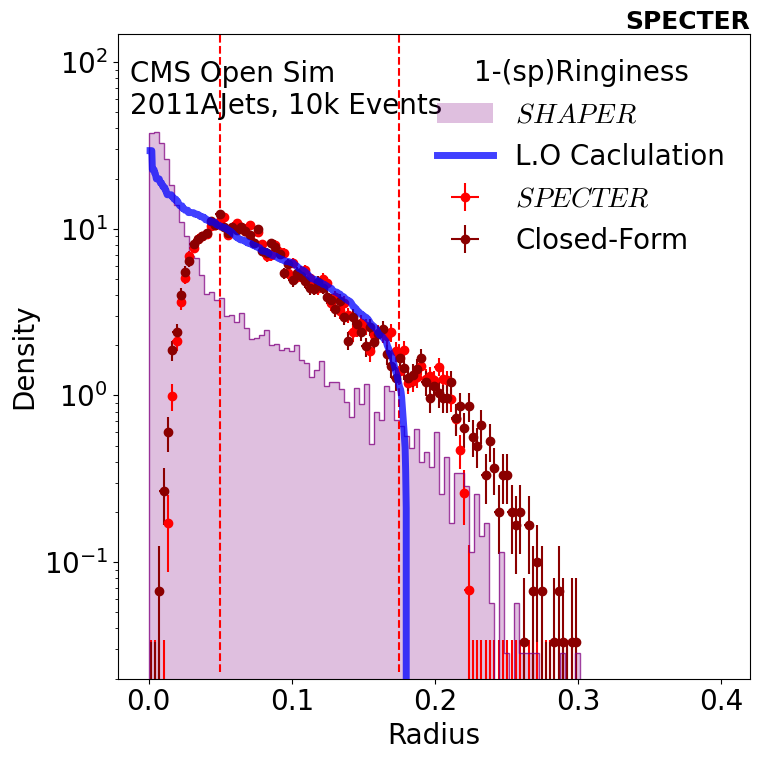

In [49]:
# Plot histograms


fig, ax = newplot()

hist_with_errors(ax, specter_params, 100, (0, 0.3), weights= weights,  label=r"$SPECTER$", color = "red")
hist_with_errors(ax, closed_form_params, 100, (0, 0.3), label="Closed-Form", color = "darkred")
hist_with_outline(ax, shaper_params, 100, (0, 0.35), label=r"$SHAPER$", color = "purple")

# plt.plot(R_opt, 0.05 * probs, color = "blue", lw = 5, alpha = 0.75, label = "L.O Caclulation", zorder = 10)
# plt.axvline(0.05, ymin = 1e-2, ymax = 1, color = "red", ls = "--")
# plt.axvline(0.175, ymin = 1e-2, ymax = 1, color = "red", ls = "--")


plt.yscale("log")

# Extend the y axis so that there is 10% space between the top of the plot
ymin, ymax = plt.ylim()
amount = 0.25
if plt.gca().get_yscale() == 'log':
    y_min, y_max = np.log10(ymin), np.log10(ymax)
    plt.ylim(np.power(10, y_min), np.power(10, y_max * (1 + amount)))
else:
    plt.ylim(ymin, ymax * (amount + 1))


print(np.mean(specter_params), np.mean(closed_form_params), np.mean(shaper_params))

# Labels
plt.xlabel("Radius")
plt.ylabel("Density")
plt.legend(frameon=False, loc="upper right", title = "1-(sp)Ringiness")

# Add two lines of text to the upper left
upper_margin = 0.96
spacing = 0.05
plt.text(0.02, upper_margin - 0 * spacing, "CMS Open Sim", transform=plt.gca().transAxes, verticalalignment='top')
plt.text(0.02, upper_margin - 1 * spacing, "2011AJets, 10k Events", transform=plt.gca().transAxes, verticalalignment='top')

Text(0.02, 0.9099999999999999, '2011AJets, 10k Events')

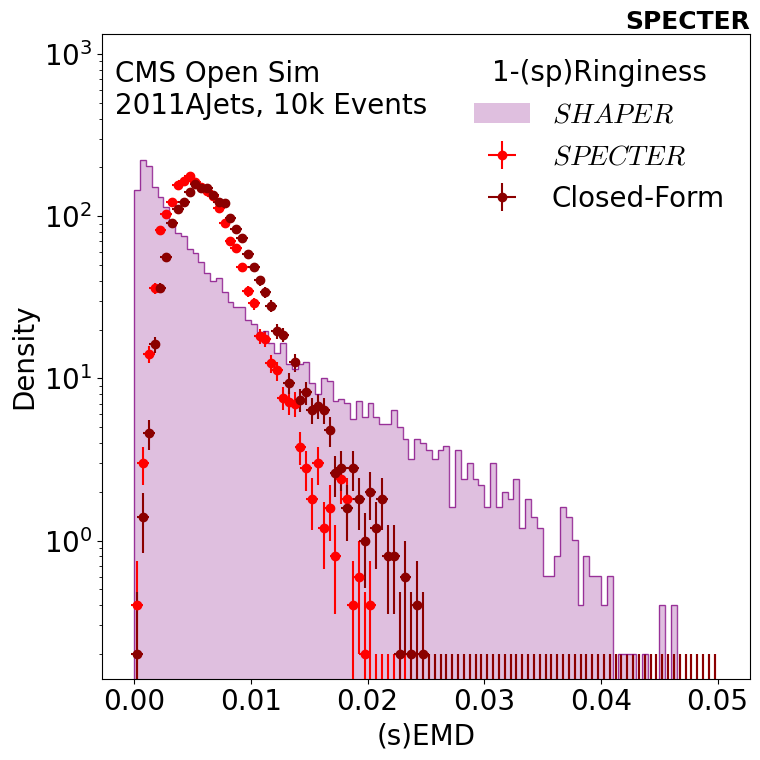

In [34]:
# Plot histograms




fig, ax = newplot()

hist_with_errors(ax, specter_emds, 100, (0, 0.05), label=r"$SPECTER$", color = "red")
hist_with_errors(ax, closed_form_emds, 100, (0, 0.05), label="Closed-Form", color = "darkred")
hist_with_outline(ax, 2 * shaper_emds ** 2, 100, (0, 0.05), label=r"$SHAPER$", color = "purple")
# plt.hist(2 * shaper_emds**2, bins=100, range = (0, 0.05), alpha=0.25, label=r"$2SHAPER^2$", density=True, color = "purple")



plt.yscale("log")

# Extend the y axis so that there is 10% space between the top of the plot
ymin, ymax = plt.ylim()
amount = 0.25
if plt.gca().get_yscale() == 'log':
    y_min, y_max = np.log10(ymin), np.log10(ymax)
    plt.ylim(np.power(10, y_min), np.power(10, y_max * (1 + amount)))
else:
    plt.ylim(ymin, ymax * (amount + 1))




# Labels
plt.xlabel("(s)EMD")
plt.ylabel("Density")
plt.legend(frameon=False, loc="upper right", title = "1-(sp)Ringiness")

# Add two lines of text to the upper left
upper_margin = 0.96
spacing = 0.05
plt.text(0.02, upper_margin - 0 * spacing, "CMS Open Sim", transform=plt.gca().transAxes, verticalalignment='top')
plt.text(0.02, upper_margin - 1 * spacing, "2011AJets, 10k Events", transform=plt.gca().transAxes, verticalalignment='top')